**DSBA 6156 Final Project**

**Model by Xavier Zuo**

In [ ]:
# Load data
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# Must set path to the actual location of the data on local google drive
path = '/content/drive/MyDrive/6156_Project_Shared/diabetes_binary_health_indicators_BRFSS2015.csv'
data = pd.read_csv(path,sep=",",)
drive.flush_and_unmount()

# Load common files and programs
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, precision_recall_fscore_support
from sklearn.metrics import average_precision_score, classification_report
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

Mounted at /content/drive


In [ ]:
# Generate X and y datasets and create train-test split
X = data.drop(columns='Diabetes_binary')
y = data['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

X_categorical = X.drop(columns=X.columns)
X_continuous = X

# Use Standard Scaler on continuous variables and use OneHotEncoder on categorical to create preprocess
preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                              X_categorical.columns),
                             (StandardScaler(), X_continuous.columns))

In [ ]:
# Varios Models Selected
# Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
# Decision Tree: max_depth=8, max_features=16
# Logistic Regression: {'logisticregression__C': 1, 'logisticregression__solver': 'lbfgs'}

clf1 = LogisticRegression(max_iter=1000,C=1)
clf2 = DecisionTreeClassifier(max_depth=8, max_features=16)
clf3 = RandomForestClassifier(max_depth=10, min_samples_leaf=1,min_samples_split=5, n_estimators=100)
clf4 = XGBClassifier()
#clf5 = LinearSVC(C=278.2559402207126)

# No decision_function in votingclassifier, can't use SVC
voting = VotingClassifier(estimators=[('lr', clf1), ('dt', clf2), ('rf', clf3), ('xgb', clf4)], voting='soft',flatten_transform=True)
voting.fit(X_train, y_train)

# CV Scoring
score_roc = cross_val_score(voting, X_train, y_train, cv=5, scoring='roc_auc')

In [ ]:
# Classification Report
y_pred1 = voting.predict(X_test)
print(f"{(classification_report(y_test, y_pred1))}")
print(f"CV Mean Score: {np.mean(score_roc)} ")

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     43667
         1.0       0.58      0.13      0.21      7069

    accuracy                           0.87     50736
   macro avg       0.73      0.56      0.57     50736
weighted avg       0.83      0.87      0.83     50736

CV Mean Score: 0.8286550424590479 


### Confusion Matrix

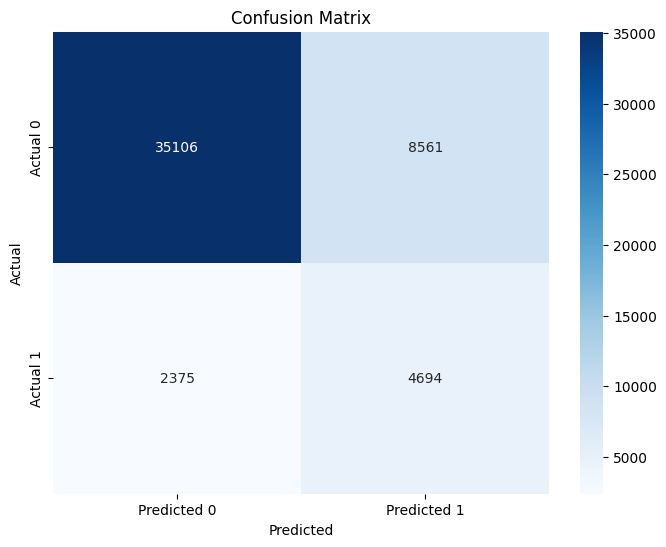

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred1)

# (Added by Xavier) Change Threshold
threshold = 0.2
y_pred1 = (voting.predict_proba(X_test)[:, 1] >= threshold).astype('float')
conf_matrix = confusion_matrix(y_test, y_pred1)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### ROC AUC

Accuracy: 0.784
Precision: 0.354
Recall: 0.664
F1 Score: 0.462
ROC AUC: 0.825


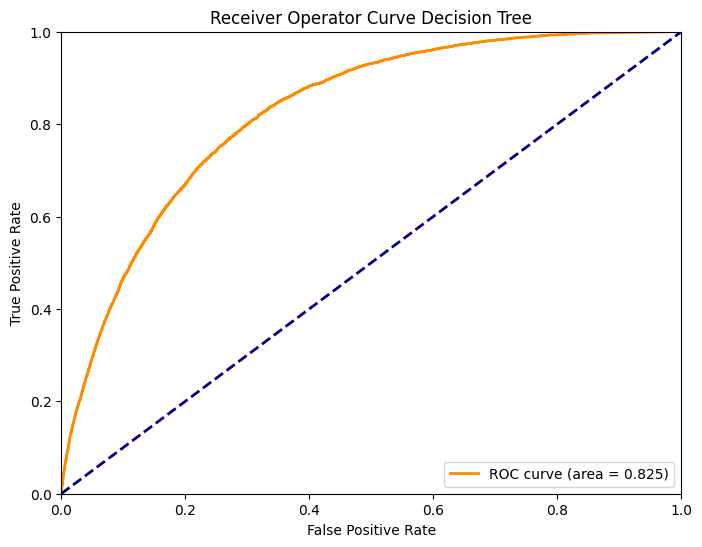

In [ ]:
# Calculate ROC AUC
y_pred_proba = voting.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)

# Print the metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add a circle at the threshold
#index = np.where(fpr >= (threshold))[0][0]
#plt.scatter(fpr[index], tpr[index], color='red', s=100, marker='o', label=f'Threshold = {threshold}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Curve Decision Tree')
plt.legend(loc="lower right")
plt.show()

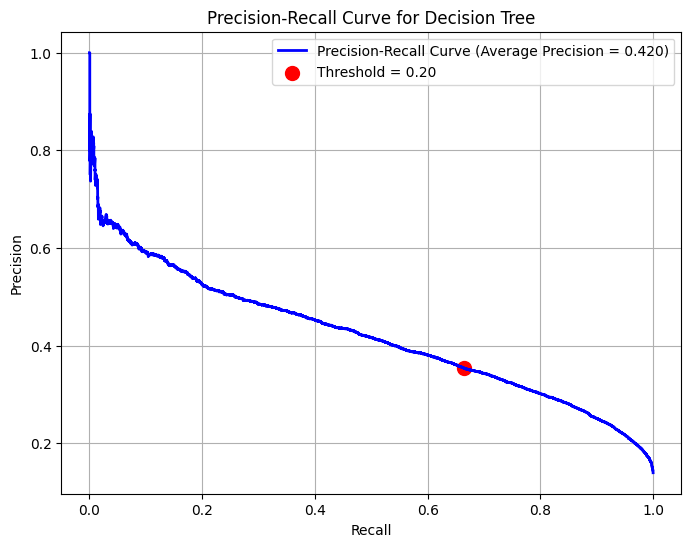

In [ ]:
# Generate Precision Recall and Average Precision

# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate Average Precision
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot the Precision-Recall Curve with Average Precision in the Legend
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall Curve (Average Precision = {average_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Decision Tree')

# (Added by Xavier) Add a circle at the threshold
# threshold = 0.25
# Find the index of the closest threshold value in the array
closest_threshold_index = np.argmin(np.abs(thresholds - threshold))
# Mark the threshold with a circle
plt.scatter(recall[closest_threshold_index], precision[closest_threshold_index], c='r', marker='o', s=100, label=f'Threshold = {thresholds[closest_threshold_index]:.2f}')

plt.legend(loc='upper right')
plt.grid(True)
plt.show()